# Lesson 6 - Building a workflow of agents with langgraph 
In the previous examples we let the agents figure out when tools or other agents we needed.
In the example we'll have more control over the flow of the execution

Inspiration from repo - https://github.com/joaomdmoura/crewAI-examples/tree/main/CrewAI-LangGraph

In [1]:
# We first install the packages
%pip install crewai langchain langchain_core langchain-openai langchain-community langgraph --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# We install our environment variables helper library
%pip install python-dotenv --quiet
import dotenv
dotenv.load_dotenv()

Note: you may need to restart the kernel to use updated packages.


True

In [3]:
# We load our helper callback to see what goes over the wire
from _callbacks import PrettyPrintCallbackHandler
callback = PrettyPrintCallbackHandler()

In [4]:
# We load the llm mode using our helper and based onthe settings
import _models
import _settings
llm=_models.get_llm(_settings.MODEL_NAME, callbacks=[callback])

In [5]:
# We load our challenge from the settings
import _settings
challenge_prompt=_settings.CHALLENGE_PROMPT

In [6]:
from langgraph.graph import StateGraph

from typing import TypedDict, Optional

# State passed around in the graph
class BashScriptState(TypedDict):
	question: str # The original question
	code: Optional[str] = None # The code that is passed around
	valid_markdown: bool # Approval stamp if valid markdown
	valid_bash: bool # Approval stamp if valid bash syntx

In [7]:
# Extraction helpers
def extract_code(code:str):
	"""Extracts the code from a markdown code block"""
	
	import re
	code = code.strip()
	code = code.replace("```bash", "")
	code = code.replace("```", "")
	code = code.strip()
	return code

def extract_markdown(code:str):
	"""Extract the markdown code block from the text"""

	question=f"extract the markdown code block from the following text:\n{code}"
	result= llm.invoke(question)
	print("======== EXTRACT MD ===================")
	print(result.content)
	print("===========================")
	
	return result.content

In [8]:
# Initialize the graph
workflow = StateGraph(BashScriptState)

In [9]:
# Prepare the nodes and edges of our workflow graph
# Action nodes
def generate_bash_code_as_markdown_node(state: BashScriptState):
	""" Asks llm to generate a bash code snippet as markdown """
	result= llm.invoke(state.get("question"))
	print(result)
	markdown = extract_markdown(result.content)
	state["code"] = markdown
	return state

def improve_code(state: BashScriptState):
	# We reset all our past validations
	state["valid_bash"] = False
	state["valid_markdown"] = False	

	# Next we ask the model to improve the existing code based on feedback
	existing_code = state.get("code")
	question = state.get("question")
	improve_question=f"extract the markdown code block from the following text:\n{existing_code}"

	result= llm.invoke(improve_question)
	print("======== IMPROVE ===================")
	print(result)
	print("===========================")
	
	state["code"] = result.content
	return state

def deploy_code(state: BashScriptState):
	print("Deploying code successfully")
	return state

In [10]:
# Validator nodes
import _tools
def check_markdown_syntax_node(state: BashScriptState):
	""" Check if the markdown code block is valid """
	code = state.get("code")
	state["valid_markdown"] = _tools.markdown_valid(code)
	return state

def check_bash_syntax_node(state: BashScriptState):
	""" Check if the bash code block is valid """

	code = state.get("code")
	state["valid_bash"] = _tools.bash_valid(extract_code(code))
	return state

In [11]:
# Approval functions
# Could be used to add human in the loop
def approve_generation(state: BashScriptState):
	print(state)
	return "valid"
	#else:
	#return "non_valid"
	
def approve_markdown_code(state: BashScriptState):
	print(state)
	if (state.get("valid_markdown")):
		return "valid"
	else:
		return "non_valid"

def approve_bash_code(state: BashScriptState):
	print(state)
	if (state.get("valid_bash")):
		return "valid"
	else:
		return "non_valid"

def approve_deploy_code(state: BashScriptState):
	print(state)
	if (state.get("valid_bash")) and (state.get("valid_markdown")):
		return "valid"
	else:
		return "non_valid"

In [12]:
# Now build the workflow

workflow.add_node("generate_bash_code_as_markdown", generate_bash_code_as_markdown_node)
workflow.add_node("check_markdown_syntax", check_markdown_syntax_node)
workflow.add_node("check_bash_syntax", check_bash_syntax_node)
#workflow.add_node("improve_code", DevOpsCrew().kickoff)

workflow.add_node("improve_code",improve_code)
workflow.add_node("deploy_code", deploy_code)

# The workflow starts at code generation
workflow.set_entry_point("generate_bash_code_as_markdown")

# Now we add the edges that check conditions and move the workflow forward
# We the first code was generated, we check if it is valid markdown
workflow.add_conditional_edges(
    "generate_bash_code_as_markdown",
	approve_generation,
	{
		"valid": "check_markdown_syntax",
		"non_valid": "improve_code"
	}
)

# When the markdown code was checked, we approve the answer
workflow.add_conditional_edges(
	"check_markdown_syntax",
	approve_markdown_code,
	{
		"valid": "check_bash_syntax",
		"non_valid": "improve_code"
	}
)

# When the bash code was checked, we approve the answer
workflow.add_conditional_edges(
	"check_bash_syntax",
	approve_bash_code,
	{
		"valid": "deploy_code",
		"non_valid": "improve_code"
	}
)

# When we do improve code, we start with checking the markdown syntax again
workflow.add_edge("improve_code", "check_markdown_syntax")
workflow.set_finish_point('deploy_code')


In [13]:
import _settings

# We compile the workflow and prepare the inputs
app = workflow.compile()
inputs = {"question": _settings.CHALLENGE_PROMPT}

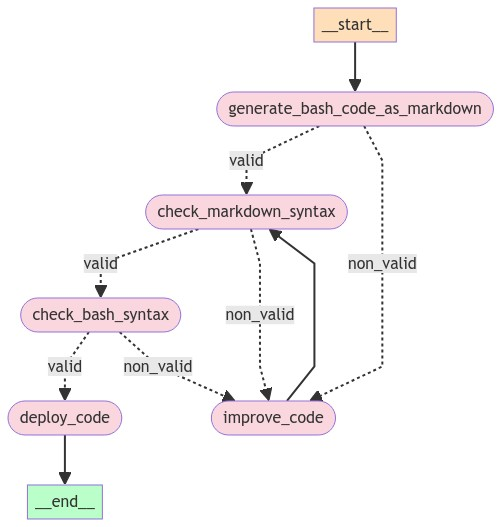

In [14]:
# We can show the workflow as a graph
from IPython.display import Image, display

graph= app.get_graph()
display(Image(graph.draw_mermaid_png()))

In [15]:
# We limit the number of executed steps in the graph to avoid infinite loops
from langchain_core.runnables import RunnableConfig
config = RunnableConfig(recursion_limit=15)

In [16]:
# We run (stream) the workflow and output the results
result=""

for event in app.stream(inputs,debug=True,    
    config=config):
    for value in event.values():
        result=value
        print(value)

#result = app.invoke(inputs)


[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'question': 'Write me a shell script to list the files in the current '
             'directory. \n'
             'Output the script as markdown code block'}
[0:writes] Finished step 0 with writes to 1 channel:
- question -> ('Write me a shell script to list the files in the current directory. \n'
 'Output the script as markdown code block')
[0:checkpoint] State at the end of step 0:
{'question': 'Write me a shell script to list the files in the current '
             'directory. \n'
             'Output the script as markdown code block'}
[1:tasks] Starting step 1 with 1 task:
- generate_bash_code_as_markdown -> {'code': None,
 'question': 'Write me a shell script to list the files in the current '
             'directory. \n'
             'Output the script as markdown code block',
 'valid_bash': None,
 'valid_markdown': None}
[chat_model][start] - prompts : Write me a shell script to list the files in the current directory. 
Out

In [17]:
print("======== FINAL RESULT ===================")
print(f"** Question: {result['question']}")
print("\n")
print(f"** Final code:\n{result["code"]}")

======== FINAL RESULT ===================
** Question: Write me a shell script to list the files in the current directory. 
Output the script as markdown code block


** Final code:
```bash
#!/bin/bash
# This script will list the files in the current directory

for file in $(ls)
do
    echo $file
done
```
